In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
mpl.rcParams["font.family"] = 'NanumBarunGothic'
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import files
uploaded=files.upload()

Saving sse.csv to sse.csv


In [4]:
import io
data=pd.read_csv(io.BytesIO(uploaded['sse.csv']))

,Date,Open,High,Low,Close,Volume,Change
0,2018-01-02,51380,51400,50780,51020,169485,0.001177
1,2018-01-03,52540,52560,51420,51620,200270,0.011760
2,2018-01-04,52120,52180,50640,51080,233909,-0.010461
3,2018-01-05,51300,52120,51200,52120,189623,0.020360
4,2018-01-08,52400,52520,51500,52020,167673,-0.001919


In [6]:
df['5days']=df['Close'].rolling(window=5).mean()
df['10days']=df['Close'].rolling(window=10).mean()
df['20days']=df['Close'].rolling(window=20).mean()
df['60days']=df['Close'].rolling(window=60).mean()
df.head()

,Date,Open,High,Low,Close,Volume,Change,5days,10days,20days,60days
0,2018-01-02,51380,51400,50780,51020,169485,0.001177,NaN,NaN,NaN,NaN
1,2018-01-03,52540,52560,51420,51620,200270,0.011760,NaN,NaN,NaN,NaN
2,2018-01-04,52120,52180,50640,51080,233909,-0.010461,NaN,NaN,NaN,NaN
3,2018-01-05,51300,52120,51200,52120,189623,0.020360,NaN,NaN,NaN,NaN
4,2018-01-08,52400,52520,51500,52020,167673,-0.001919,51572.0,NaN,NaN,NaN


In [9]:
df=df[df['Open']!=0]

In [10]:

df.fillna(0, inplace=True)
df.head()


,Date,Open,High,Low,Close,Volume,Change,5days,10days,20days,60days,120days
0,2018-01-02,51380,51400,50780,51020,169485,0.001177,0.0,0.0,0.0,0.0,0.0
1,2018-01-03,52540,52560,51420,51620,200270,0.011760,0.0,0.0,0.0,0.0,0.0
2,2018-01-04,52120,52180,50640,51080,233909,-0.010461,0.0,0.0,0.0,0.0,0.0
3,2018-01-05,51300,52120,51200,52120,189623,0.020360,0.0,0.0,0.0,0.0,0.0
4,2018-01-08,52400,52520,51500,52020,167673,-0.001919,51572.0,0.0,0.0,0.0,0.0


In [12]:
df.drop(['Open','High','Low','Volume','Change'],axis=1,inplace=True)
df.head()

,Date,Close,5days,10days,20days,60days,120days
0,2018-01-02,51020,0.0,0.0,0.0,0.0,0.0
1,2018-01-03,51620,0.0,0.0,0.0,0.0,0.0
2,2018-01-04,51080,0.0,0.0,0.0,0.0,0.0
3,2018-01-05,52120,0.0,0.0,0.0,0.0,0.0
4,2018-01-08,52020,51572.0,0.0,0.0,0.0,0.0


In [13]:
df.set_index('Date',inplace=True)

In [14]:
scaler=MinMaxScaler()
scale_cols=['Close','5days','10days','20days','60days']
df_scaled=scaler.fit_transform(df[scale_cols])

In [15]:
df_scaled=pd.DataFrame(df_scaled)
df_scaled.columns=scale_cols
print(df_scaled)

        Close     5days    10days    20days    60days
0    0.543888  0.000000  0.000000  0.000000  0.000000
1    0.567936  0.000000  0.000000  0.000000  0.000000
2    0.546293  0.000000  0.000000  0.000000  0.000000
3    0.587976  0.000000  0.000000  0.000000  0.000000
4    0.583968  0.836665  0.000000  0.000000  0.000000
..        ...       ...       ...       ...       ...
605  0.619238  0.848475  0.859895  0.879674  0.869076
606  0.579158  0.847177  0.855943  0.880923  0.870115
607  0.635271  0.848475  0.857590  0.883088  0.871687
608  0.599198  0.849773  0.861706  0.884087  0.873028
609  0.615230  0.854315  0.862858  0.885253  0.875047

[610 rows x 5 columns]


In [16]:
TEST_SIZE=100
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [17]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [19]:
feature_cols = ['5days','10days','20days','60days']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2,shuffle=False)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(392, 20, 4) (392, 1)
(98, 20, 4) (98, 1)


In [20]:
test_feature=test[feature_cols]
test_label=test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((80, 20, 4), (80, 1))

In [21]:
model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1344      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='mse',optimizer='adam',metrics=['mse'])

from keras.callbacks import EarlyStopping
early_stopping=EarlyStopping(patience=20,monitor='val_loss')
history=model.fit(x_train,y_train,epochs=100,batch_size=1,validation_split=0,callbacks=[early_stopping])

Epoch 1/100
392/392 [==============================] - 1s 4ms/step - loss: 0.0275 - mse: 0.0275
Epoch 2/100
392/392 [==============================] - 1s 4ms/step - loss: 0.0111 - mse: 0.0111
Epoch 3/100
392/392 [==============================] - 1s 4ms/step - loss: 0.0099 - mse: 0.0099
Epoch 4/100
392/392 [==============================] - 1s 4ms/step - loss: 0.0093 - mse: 0.0093
Epoch 5/100
392/392 [==============================] - 2s 4ms/step - loss: 0.0082 - mse: 0.0082
Epoch 6/100
392/392 [==============================] - 1s 4ms/step - loss: 0.0073 - mse: 0.0073
Epoch 7/100
392/392 [==============================] - 1s 4ms/step - loss: 0.0072 - mse: 0.0072
Epoch 8/100
392/392 [==============================] - 1s 4ms/step - loss: 0.0061 - mse: 0.0061
Epoch 9/100
392/392 [==============================] - 1s 4ms/step - loss: 0.0059 - mse: 0.0059
Epoch 10/100
392/392 [==============================] - 1s 4ms/step - loss: 0.0054 - mse: 0.0054
Epoch 11/100
392/392 [=================

In [25]:
pred=model.predict(test_feature)

In [26]:
pred.shape

(80, 1)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


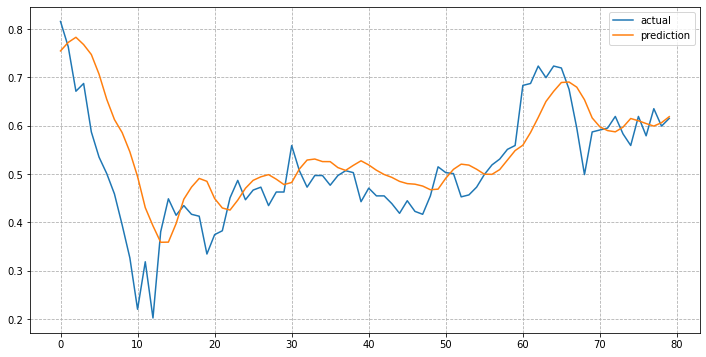

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.grid(ls='--')
plt.show()

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


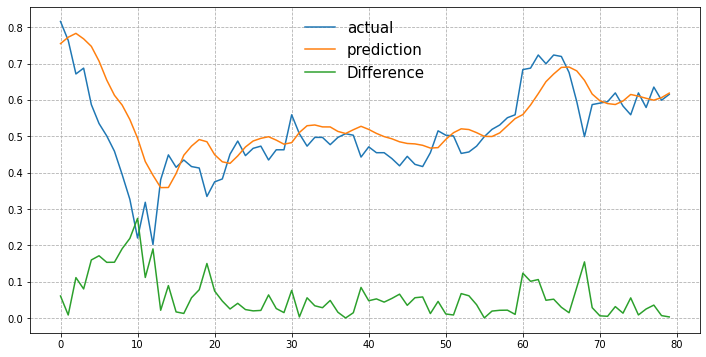

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.plot(np.sqrt((pred - test_label)**2), label='Difference')
plt.legend(frameon=False, fontsize = 15)
plt.grid(ls='--')
plt.show()

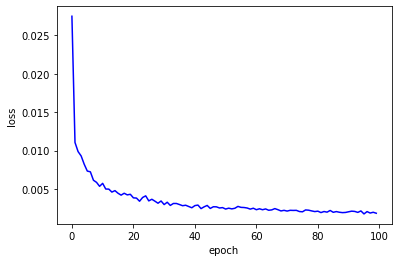

In [29]:
#훈련 손실값loss
fig, loss_ax=plt.subplots()
loss_ax.plot(history.history['loss'], 'b', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
plt.show()

In [30]:
mse=mean_squared_error(test_label, pred)
rmse=np.sqrt(mse)
rmse

0.08137686298004031

In [31]:
print(pred)

[[0.7546936 ]
 [0.77233046]
 [0.78292245]
 [0.76782244]
 [0.74726385]
 [0.7066737 ]
 [0.6545595 ]
 [0.61272573]
 [0.58581954]
 [0.546029  ]
 [0.4948684 ]
 [0.430627  ]
 [0.3929047 ]
 [0.35896808]
 [0.35926175]
 [0.39752644]
 [0.4479394 ]
 [0.4730327 ]
 [0.49099892]
 [0.48502505]
 [0.44949692]
 [0.42988646]
 [0.42555976]
 [0.4460734 ]
 [0.47062945]
 [0.48707038]
 [0.4943589 ]
 [0.49886328]
 [0.4894582 ]
 [0.47827965]
 [0.48260075]
 [0.5104525 ]
 [0.5290353 ]
 [0.5311346 ]
 [0.5258368 ]
 [0.52573323]
 [0.5133867 ]
 [0.5076355 ]
 [0.51803005]
 [0.5274639 ]
 [0.5189017 ]
 [0.50796616]
 [0.49914217]
 [0.493196  ]
 [0.48488533]
 [0.48028833]
 [0.47909373]
 [0.4752466 ]
 [0.46762598]
 [0.4688552 ]
 [0.49139535]
 [0.50984824]
 [0.5205305 ]
 [0.5185637 ]
 [0.5100193 ]
 [0.4998064 ]
 [0.49945593]
 [0.5093248 ]
 [0.52900916]
 [0.5486337 ]
 [0.55968565]
 [0.58594984]
 [0.6171965 ]
 [0.65011513]
 [0.67117727]
 [0.68940747]
 [0.6903651 ]
 [0.67975366]
 [0.6537833 ]
 [0.61614794]
 [0.59768236]
 [0.58

In [34]:
loss, mae=model.evaluate(x_train, y_train, batch_size=1)
print(loss, mae)
#mae는 오차의 절대값: 0이 제일 정확

392/392 [==============================] - 1s 1ms/step - loss: 0.0041 - mse: 0.0041
0.004054630640894175 0.004054630640894175


Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


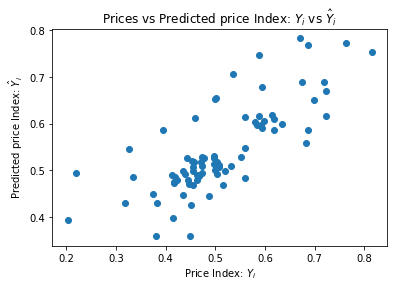

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(test_label, pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")
#예측값과 원래값이 일치하면 직선에 가깝게 분포됨

In [36]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
valScore = model.evaluate(x_valid, y_valid, verbose=0)
print('Validataion Score: ', valScore)
testScore = model.evaluate(test_feature,test_label, verbose=0)
print('Test Score: ', testScore)

Train Score:  [0.004054631572216749, 0.004054631572216749]
Validataion Score:  [0.002628313610330224, 0.002628313610330224]
Test Score:  [0.006622193846851587, 0.006622193846851587]
